In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch

import torch
from torch.utils.data import Dataset
import pandas as pd
import os


class ProteinDataset(Dataset):
    def __init__(self, sequences_csv, labels_csv, pssm_dir):
        self.labels_df = pd.read_csv(labels_csv)
        self.sequences_df = pd.read_csv(sequences_csv)
        self.pssm_dir = pssm_dir
#         self.pdb_ids = self.labels_df['PDB_ID'].unique()


    def __len__(self):
        return len(self.sequences_df)

    def __getitem__(self, idx):
#         pdb_id = self.pdb_ids[idx]
        pdb_id = self.sequences_df.iloc[idx]['PDB_ID']
        sequence = self.sequences_df.iloc[idx]['SEQUENCE']
        label = self.labels_df[self.labels_df['PDB_ID'] == pdb_id]['SEC_STRUCT'].values[0]

        # load file with PSSM profiles
        pssm_path = os.path.join(self.pssm_dir, f"{pdb_id}_train.csv")
        pssm_df = pd.read_csv(pssm_path, usecols=lambda column : column not in ["RES_NUM", "AMINO_ACID"])
        # transpose, with NaN
        pssm_df = pssm_df.apply(pd.to_numeric, errors='coerce').fillna(0)
        pssm_tensor = torch.tensor(pssm_df.values, dtype=torch.float32).T  # transpose [sequence_length, num_amino_acids]

        # encode label
        label_encoded = encode_label(label)

        return pssm_tensor, label_encoded

# pre-defined encode_label function, encode labels into integer
def encode_label(label):
    label_dict = {'H': 0, 'E': 1, 'C': 2}  # 0-2
    return torch.tensor([label_dict[aa] for aa in label], dtype=torch.long)



In [2]:
import torch.nn as nn
import torch.nn.functional as F

class FullyConvNet(nn.Module):
    def __init__(self, num_classes):
        super(FullyConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=20, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.final_conv = nn.Conv1d(256, num_classes, kernel_size=1)

    def forward(self, x):
        # Assuming `x` is your input tensor with shape [32, 1231, 20]
        x = x.permute(0, 2, 1)  # Permute to get [batch_size, num_channels, sequence_length]

        # Now, `x` has the shape [32, 20, 1231], which matches the expected input shape of the Conv1D layer
#         x = F.relu(self.bn1(self.conv1(x)))

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.final_conv(x)
        return F.log_softmax(x, dim=1)  # using log_softmax for NLLLoss


In [3]:
import matplotlib.pyplot as plt
def save_model_and_optimizer(model, optimizer, save_path="model_checkpoint.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, save_path)
    print(f"Model and optimizer state dicts saved to {save_path}")



def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    train_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            # print("outputs: ", outputs.shape)

            outputs = outputs.permute(0, 2, 1)  # [batch_size, sequence_length, num_classes]
            outputs_flat = outputs.reshape(-1, num_classes)  # Flatten
            labels_flat = labels.view(-1)  # Flatten labels  to [batch_size * sequence_length]

            # print("outputs_flat: ", outputs_flat.shape)
            # print("labels_flat: ", labels_flat.shape)

            optimizer.zero_grad()
            loss = criterion(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs_flat, 1)
            mask = labels_flat != -1  # Assuming -1 is the padding value
            correct_predictions = predicted[mask] == labels_flat[mask]
            total_correct += correct_predictions.sum().item()
            total_samples += mask.sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        save_model_and_optimizer(model, optimizer, "model_checkpoint.pth")

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Plotting the training loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [7]:
from torch.utils.data import DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

def collate_fn(batch):
    sequences, labels = zip(*batch)

    # Your sequence handling code here...
    sequences_transposed = [seq.transpose(0, 1) for seq in sequences]  # This might already be correct depending on your data
    sequences_padded = pad_sequence(sequences_transposed, batch_first=True, padding_value=0)

    # Handling variable-length label sequences
    # Convert labels to tensors if they aren't already
#     labels_tensors = [torch.tensor(label, dtype=torch.long) for label in labels]
    # Adjusted line to create new tensors from existing ones
    labels_tensors = [label.clone().detach().long() for label in labels]

    # Pad label sequences so they all have the same length
    labels_padded = pad_sequence(labels_tensors, batch_first=True, padding_value=-1)  # Assuming -1 is an appropriate padding value for your task

    return sequences_padded, labels_padded




# set pssm files folders
sequences_csv = '/kaggle/input/msc-data/seqs_train.csv'
labels_csv = '/kaggle/input/msc-data/labels_train.csv'
pssm_dir = '/kaggle/input/msc-data/train/'

# initial dataset and load data loader
train_dataset = ProteinDataset(sequences_csv, labels_csv, pssm_dir)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# creating DataLoader using collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# # defin device(GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# # initilize model
# num_classes = 3  # classes：Helix, Sheet, Coil
# model = FullyConvNet(num_classes).to(device)

# # define loss function & optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1)
# optimizer = Adam(model.parameters(), lr=1e-4)

# # # train model, 5 epoches for test
# # num_epochs = 5
# # train_model(model, train_loader, criterion, optimizer, num_epochs, device)


cuda


In [ ]:

# save model's states and dicts
save_model_and_optimizer(model, optimizer, "model_checkpoint.pth")


In [ ]:
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim

def load_model_and_optimizer(model, optimizer, load_path="/kaggle/working/model_checkpoint.pth"):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model and optimizer state dicts loaded from {load_path}")

# settings:
num_classes =3
model = FullyConvNet(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# load model and optimizer
checkpoint = torch.load("/kaggle/input/model/pytorch/28/1/model_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# prepare for loss and accuracy counts
train_losses = []
train_accuracy = []

# continue to train
num_epochs = 50
train_model(model, train_loader, criterion, optimizer, num_epochs, device)
save_model_and_optimizer(model, optimizer, "model_checkpoint.pth")


Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 1/50, Loss: 0.5638, Accuracy: 0.7693
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 2/50, Loss: 0.5568, Accuracy: 0.7720
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 3/50, Loss: 0.5517, Accuracy: 0.7749
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 4/50, Loss: 0.5460, Accuracy: 0.7772
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 5/50, Loss: 0.5419, Accuracy: 0.7790
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 6/50, Loss: 0.5380, Accuracy: 0.7810
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 7/50, Loss: 0.5352, Accuracy: 0.7818
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 8/50, Loss: 0.5303, Accuracy: 0.7843
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 9/50, Loss: 0.5280, Accuracy: 0.7851
Model and optimizer state dicts saved to model_checkpoi

again after 30

Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 1/30, Loss: 0.4858, Accuracy: 0.8044
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 2/30, Loss: 0.4839, Accuracy: 0.8050
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 3/30, Loss: 0.4827, Accuracy: 0.8053
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 4/30, Loss: 0.4819, Accuracy: 0.8060
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 5/30, Loss: 0.4798, Accuracy: 0.8067
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 6/30, Loss: 0.4780, Accuracy: 0.8078
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 7/30, Loss: 0.4780, Accuracy: 0.8075
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 8/30, Loss: 0.4771, Accuracy: 0.8078
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 9/30, Loss: 0.4760, Accuracy: 0.8086
Model and optimizer state dicts saved to model_checkpoi

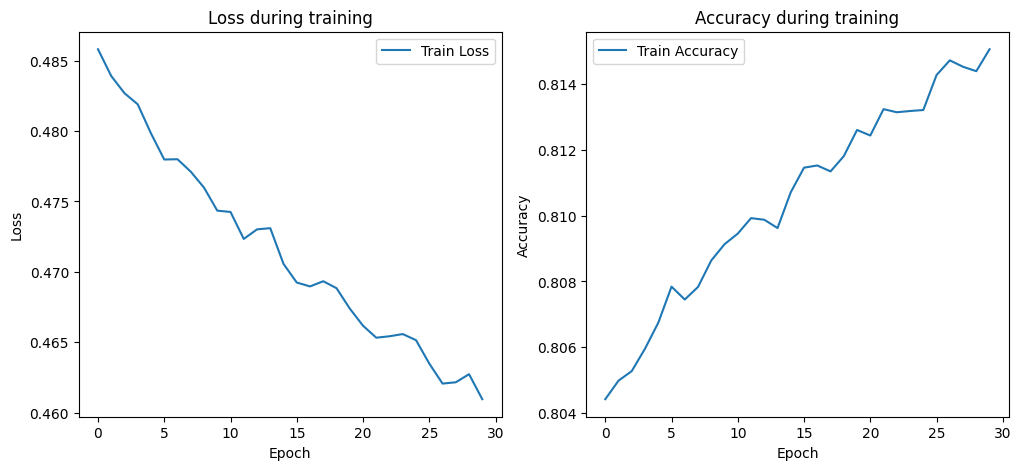

Model and optimizer state dicts saved to model_checkpoint.pth


In [7]:
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim


# settings:
num_classes =3
model = FullyConvNet(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# load model and optimizer
checkpoint = torch.load("/kaggle/input/new/pytorch/test/1/model_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# prepare for loss and accuracy counts
train_losses = []
train_accuracy = []

# continue to train
num_epochs = 30
train_model(model, train_loader, criterion, optimizer, num_epochs, device)
save_model_and_optimizer(model, optimizer, "model_checkpoint.pth")


again start for 80, run 30 epoches

In [ ]:
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim


# settings:
num_classes =3
model = FullyConvNet(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# load model and optimizer
checkpoint = torch.load("/kaggle/input/new/pytorch/acc80/1/model_checkpoint-acc80.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# prepare for loss and accuracy counts
train_losses = []
train_accuracy = []

# continue to train
num_epochs = 30
train_model(model, train_loader, criterion, optimizer, num_epochs, device)
save_model_and_optimizer(model, optimizer, "model_checkpoint.pth")


Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 1/30, Loss: 0.4600, Accuracy: 0.8155
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 2/30, Loss: 0.4598, Accuracy: 0.8159
Model and optimizer state dicts saved to model_checkpoint.pth
Epoch 3/30, Loss: 0.4594, Accuracy: 0.8156


In [9]:
import torch
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import csv

# 保留之前定义的encode_amino_acid和encode_sequence函数

class TestProteinDataset(Dataset):
    def __init__(self, sequences_csv, test_dir):
        self.sequences_df = pd.read_csv(sequences_csv)
        self.pssm_dir = test_dir


    def __getitem__(self, idx):
        pdb_id = self.sequences_df.iloc[idx]['PDB_ID']
        sequence = self.sequences_df.iloc[idx]['SEQUENCE']

        # 加载PSSM文件
        pssm_path = os.path.join(self.pssm_dir, f"{pdb_id}_test.csv")
        pssm_df = pd.read_csv(pssm_path, usecols=lambda column : column not in ["RES_NUM", "AMINO_ACID"])
        # 转换为数值类型，并填充NaN值
        pssm_df = pssm_df.apply(pd.to_numeric, errors='coerce').fillna(0)
        pssm_tensor = torch.tensor(pssm_df.values, dtype=torch.float32).T  # 转置以匹配模型输入 [sequence_length, num_amino_acids]


        return pssm_tensor, pdb_id

    def __len__(self):
        return len(self.sequences_df)


def predict_collate_fn(batch):
    sequences, pdb_ids = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    return sequences_padded, pdb_ids


def predict(model, loader, device):
    model.eval()
    predictions = {}

    with torch.no_grad():
        for sequences, pdb_ids in loader:
            sequences = sequences.to(device)
            sequences = sequences.permute(0, 2, 1)  # 将sequences的维度从[batch_size, sequence_length, channels]转换为[batch_size, channels, sequence_length]

            output = model(sequences)  # 假设输出维度为 (batch_size, num_classes, sequence_length)

            # 由于batch_size=1，直接处理每个batch
            for i, pdb_id in enumerate(pdb_ids):
                output_seq = output[i]  # 输出形状应为 (num_classes, sequence_length)
                _, predicted_seq = torch.max(output_seq, dim=0)  # 对每个位置取最大值获取类别

                # 保存预测结果
                if pdb_id not in predictions:
                    predictions[pdb_id] = []
                predictions[pdb_id].extend(predicted_seq.cpu().numpy())

    return predictions

# 以下是你之前的代码
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('/kaggle/working/model_checkpoint.pth')
num_classes = 3
model = FullyConvNet(num_classes).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

test_dataset = TestProteinDataset(sequences_csv='/kaggle/input/msc-data/seqs_test.csv', test_dir='/kaggle/input/msc-data/test/')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=predict_collate_fn)

predictions = predict(model, test_loader, device)
print((predictions))


output_path = 'submission-acc80-2.csv'

with open(output_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ID', 'STRUCTURE'])
    for pdb_id, pred_labels in predictions.items():
        for residue_index, residue_prediction in enumerate(pred_labels):
            residue_id = f'{pdb_id}_{residue_index + 1}'  # 构建残基ID，索引从1开始
            prediction_label = 'H' if residue_prediction == 0 else ('E' if residue_prediction == 1 else 'C')
            # 将每个残基的预测标签写入CSV文件
            csvwriter.writerow([residue_id, prediction_label])

print(f"Predictions have been saved to {output_path}")


{'2AIO_1_A': [2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2], '2FR2_1_A': [2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 